In [1]:
import os
import random
import numpy as np
import pandas as pd

def load_ratings(filename):
    try:
        raw_matrix = np.loadtxt(filename)
        return np.ma.array(raw_matrix, dtype=np.int, copy=False,
                              mask=raw_matrix <= 0, fill_value=0, hard_mask=True)
    except:
        print("Error: Could not load rating file '%s'" % filename)
        exit()

data_path = '../coat-origin/'
feature_path = '../coat-origin/user_item_features/'

train_matrix = np.loadtxt(data_path + "train.ascii")
test_matrix = np.loadtxt(data_path + "test.ascii")
print(train_matrix.shape, test_matrix.shape)

(290, 300) (290, 300)


In [2]:
train_list = []
train_dict = {}
train_neg_list = []
for u in range(train_matrix.shape[0]):
    if u not in train_dict:
        train_dict[u] = []
    for i in range(train_matrix.shape[1]):
        if train_matrix[u][i]>3:
            train_dict[u].append(i)
            train_list.append([u,i])

print('len train_list:', len(train_list))
print('len train_dict', len(train_dict))

len train_list: 1905
len train_dict 290


In [3]:
test_list0 = []
test_dict0 = {}
for u in range(test_matrix.shape[0]):
    if u not in test_dict0:
        test_dict0[u] = []
    for i in range(test_matrix.shape[1]):
        if test_matrix[u][i]>3:
            test_dict0[u].append(i)
            test_list0.append([u,i])

print('len test_list0:', len(test_list0))
print('len test_dict0', len(test_dict0))

len test_list0: 860
len test_dict0 290


In [4]:
valid_dict = {}
test_dict = {}
for u in test_dict0:
    items = test_dict0[u]
    if (len(items) > 2):
        valid_dict[u] = items[:-int(len(items)/2)] # valid >= test
        test_dict[u] = items[-int(len(items)/2):]
    else:
        continue
print('len test_dict:', len(test_dict))

len test_dict: 131


In [5]:
np.save('./sets/training_list.npy', np.array(train_list))
np.save('./sets/training_dict.npy', np.array(train_dict))
np.save('./sets/validation_dict.npy', np.array(valid_dict))
np.save('./sets/testing_dict.npy', np.array(test_dict))

In [6]:
item_features_matrix = np.loadtxt(feature_path + "item_features.ascii")
item_type_matrix = item_features_matrix[:,2:18] # jacket type features

In [7]:
item_feature_dict = {}
for i in range(item_type_matrix.shape[0]):
    for c in range(item_type_matrix.shape[1]):
        if item_type_matrix[i][c] == 1:
            item_feature_dict[i] = [c]

category_list = list(range(item_type_matrix.shape[1]))

np.save('./features/item_feature_dict.npy', np.array(item_feature_dict))
np.save('./features/category_list.npy', np.array(category_list))

In [9]:
pop_rank = dict(pd.DataFrame(train_list)[1].value_counts())
print(len(pop_rank))
for i in range(train_matrix.shape[1]):
    if i not in pop_rank:
        pop_rank[i] = 0
print(len(pop_rank))

item_rank_dict = {} #id:rank
rank = 0
for element in pop_rank:
    item_rank_dict[element] = rank
    rank += 1
np.save('./features/item_rank_dict.npy', np.array(item_rank_dict))

284
300


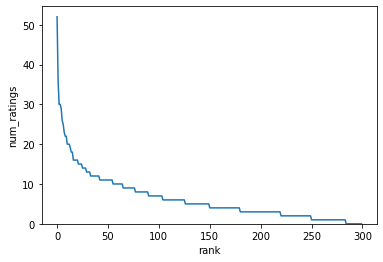

In [10]:
import matplotlib.pyplot as plt
a = pop_rank.values()
plt.plot(a)
plt.ylim(bottom=0.)
#ax.set_xlim(left=0.)
plt.xlabel("rank")
plt.ylabel("num_ratings")
plt.show()

In [11]:
category_num = len(category_list)
topk_category = 3
user_fml_cat_big = {}
for user in train_dict:
    category_cnt = [0] * category_num
    for item in train_dict[user]:
        for cat in item_feature_dict[item]:
            category_cnt[cat] += 1
    sorted_list = list(np.argsort(category_cnt))
    fml_cat = sorted_list[-topk_category:]
    user_fml_cat_big[user] = fml_cat
np.save('./features/user_fml_cat.npy', np.array(user_fml_cat_big))

In [12]:
category_num = len(category_list)
user_fml_cat_big = {}
for user in train_dict:
    category_cnt = [0] * category_num
    for item in train_dict[user]:
        #print(item_feature_dict[item])
        for cat in item_feature_dict[item]:
            category_cnt[cat] += 1/len(item_feature_dict[item])
    pscore = (np.array(category_cnt) / max(category_cnt)) #** 0.5
    user_fml_cat_big[user] = pscore.tolist()
np.save('./features/IPS.npy', np.array(user_fml_cat_big))
np.save('./features/IPS_item_cal.npy', np.array(item_feature_dict))

In [13]:
user_feature_file = {}
for userID in train_dict:
    user_feature_file[userID] = [['U'+str(userID)]]
    user_feature_file[userID].append([str(1)]*len(user_feature_file[userID][0]))

item_feature_file = {}
for itemID in item_feature_dict:
    item_feature_file[itemID] = [['I'+str(itemID)]]
    item_feature_file[itemID].append(['1'])
    for cate in range(0, len(category_list)):
        if cate in item_feature_dict[itemID]:
            item_feature_file[itemID][0].append('IC'+str(cate))
            item_feature_file[itemID][1].append(str(round(1.0/len(item_feature_dict[itemID]), 2)))
        else:
            item_feature_file[itemID][0].append('IC'+str(cate))
            item_feature_file[itemID][1].append(str(0))
np.save('./features/user_feature_file.npy', np.array(user_feature_file))
np.save('./features/item_feature_file.npy', np.array(item_feature_file))

In [16]:
item_cat_vec = {}
for itemID in item_feature_dict:
    item_cat_vec[itemID] = [0] * category_num
    cat_num = len(item_feature_dict[itemID])
    for cat in item_feature_dict[itemID]:
        item_cat_vec[itemID][cat] = 1 / np.sqrt(cat_num)
np.save('./features/item_cat_vec.npy', np.array(item_cat_vec))